In [ ]:
!wget https://file.io/7xJlFivXZdfL
!unzip 7xJlFivXZdfL

import os

base_dir = '/content/flood'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

os.makedirs(base_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Subdirectories for 'street view floods' and 'other' categories
train_street_dir = os.path.join(train_dir, 'street_view')
train_other_dir = os.path.join(train_dir, 'other')
validation_street_dir = os.path.join(validation_dir, 'street_view')
validation_other_dir = os.path.join(validation_dir, 'other')

os.makedirs(train_street_dir, exist_ok=True)
os.makedirs(train_other_dir, exist_ok=True)
os.makedirs(validation_street_dir, exist_ok=True)
os.makedirs(validation_other_dir, exist_ok=True)


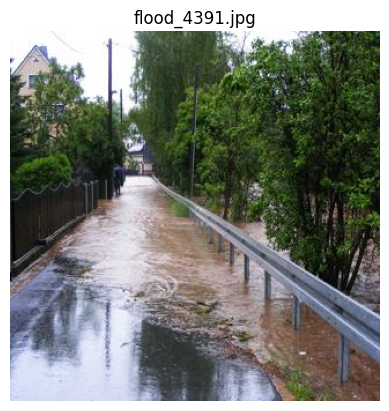

Button(description='Train Street', style=ButtonStyle())

Button(description='Train Not Street', style=ButtonStyle())

Button(description='Validation Street', style=ButtonStyle())

Button(description='Validation Not Street', style=ButtonStyle())

In [ ]:
import os
import matplotlib.pyplot as plt
import shutil
from IPython.display import clear_output
from ipywidgets import widgets

# Setting up the directory paths
images_dir='/content/re_test_data/trainA/'

all_images = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]

# Defining the button action function
def on_button_click(button, img_file, category):
    if category == "train_street":
        shutil.move(os.path.join(images_dir, img_file), os.path.join(train_street_dir, img_file))
    elif category == "train_other":
        shutil.move(os.path.join(images_dir, img_file), os.path.join(train_other_dir, img_file))

    clear_output(wait=True)
    display_next_image()

# Function to display next image and buttons
def display_next_image():
    if not all_images:
        print("All images processed!")
        return

    img_file = all_images.pop(0)
    img_path = os.path.join(images_dir, img_file)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(img_file)
    plt.axis('off')
    plt.show()

    button_train_street = widgets.Button(description="Train Street")
    button_train_other = widgets.Button(description="Train Not Street")
    button_validation_street = widgets.Button(description="Validation Street")
    button_validation_other = widgets.Button(description="Validation Not Street")

    button_train_street.on_click(lambda b: on_button_click(b, img_file, "train_street"))
    button_train_other.on_click(lambda b: on_button_click(b, img_file, "train_other"))
    button_validation_street.on_click(lambda b: on_button_click(b, img_file, "validation_street"))
    button_validation_other.on_click(lambda b: on_button_click(b, img_file, "validation_other"))

    display(button_train_street, button_train_other)

# Start by displaying the first image
display_next_image()


In [ ]:
import os
import random
import shutil

street_view_dir = "/content/flood/train/street_view"
other_view_dir = "/content/flood/train/other"

street_view_count = len(os.listdir(street_view_dir))
other_view_count = len(os.listdir(other_view_dir))

# Calculate how many "other view" images to remove
num_to_remove = other_view_count - street_view_count

# Randomly select files and move to a temporary directory (in case you want to revert changes)
other_files = os.listdir(other_view_dir)
files_to_remove = random.sample(other_files, num_to_remove)

temp_dir = "/content/flood/temp_other"
os.makedirs(temp_dir, exist_ok=True)

for file in files_to_remove:
    source_path = os.path.join(other_view_dir, file)
    dest_path = os.path.join(temp_dir, file)
    shutil.move(source_path, dest_path)

print(f"Moved {num_to_remove} files from 'other' to a temporary directory.")


Moved 92 files from 'other' to a temporary directory.


In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight

# Paths
train_dir = '/content/flood/train'

# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,      # Randomly rotate the image (max rotation of 40 degrees)
    width_shift_range=0.2,  # Randomly shift the image horizontally
    height_shift_range=0.2, # Randomly shift the image vertically
    shear_range=0.2,        # Randomly apply shearing transformations
    zoom_range=0.2,         # Randomly zoom inside the image
    horizontal_flip=True,   # Randomly flip the image horizontally
    fill_mode='nearest'     # Fill any empty pixels caused by the augmentations
)

num_train_samples = sum([len(files) for r, d, files in os.walk(train_dir)])
batch_size = 20  # as per your original code

steps_per_epoch = num_train_samples // batch_size

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')


# Model with VGG16 for transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30
)

# Save Model
model.save('street_view_flood_model.h5')


In [ ]:
import os
import shutil

all_images_path = '/content/flood_cleanup/trainA'
predicted_street_path = 'street'
predicted_other_path = 'other'

if not os.path.exists(predicted_street_path):
    os.makedirs(predicted_street_path)

if not os.path.exists(predicted_other_path):
    os.makedirs(predicted_other_path)

for filename in os.listdir(all_images_path):
    if '.jpg' not in filename:
      continue
    img_path = os.path.join(all_images_path, filename)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # Rescale

    prediction = model.predict(x)

    # Move the file based on prediction
    if prediction[0][0] < 0.5:  # adjust the threshold as needed
        shutil.copy(img_path, os.path.join(predicted_other_path, filename))
    else:
        shutil.copy(img_path, os.path.join(predicted_street_path, filename))

In [ ]:
!mkdir /content/re_test_data_clean/trainA
!mkdir /content/re_test_data_clean/trainA_seg
!mkdir /content/re_test_data_clean/trainB
!mkdir /content/re_test_data_clean/trainB_seg

In [ ]:
import os
import shutil

def move_files(source_folder, destination_folder):
    # List all files in the source folder
    files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]

    # Ensure the destination folder exists, if not, create it
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Move each file to the destination folder
    for file_name in files:
        source_path = os.path.join(source_folder, file_name)
        destination_path = os.path.join(destination_folder, file_name)

        seg_name = file_name.replace('.jpg','.png')
        seg_source_path = os.path.join('/content/flood_cleanup/trainA_seg', seg_name)
        seg_destination_path = os.path.join('/content/re_test_data_clean/trainA_seg', file_name)
        # Move the file
        shutil.copy(source_path, destination_path)
        shutil.copy(seg_source_path, seg_destination_path)
        print(f"Moved {file_name} from {source_folder} to {destination_folder}")
        print(f"Moved {seg_name} from {seg_source_path} to {seg_destination_path}")

# Define your source and destination folder paths
source = "/content/street"
destination = "/content/re_test_data_clean/trainA"

move_files(source, destination)


In [ ]:
#!rm -f /content/re_test_data_clean/trainA/*
#!rm -f /content/re_test_data_clean/trainA_seg/*

In [ ]:
!find /content/re_test_data_clean/trainA -type f | wc -l
!find /content/re_test_data_clean/trainA_seg -type f | wc -l

1592
1592


In [ ]:
!zip -r re_test_data_clean.zip re_test_data_clean/

updating: re_test_data_clean/ (stored 0%)
  adding: re_test_data_clean/trainA/ (stored 0%)
  adding: re_test_data_clean/trainA/flood_3679.jpg (deflated 3%)
  adding: re_test_data_clean/trainA/flood_3843.jpg (deflated 2%)
  adding: re_test_data_clean/trainA/flood_2169.jpg (deflated 4%)
  adding: re_test_data_clean/trainA/flood_1633.jpg (deflated 3%)
  adding: re_test_data_clean/trainA/flood_1100.jpg (deflated 1%)
  adding: re_test_data_clean/trainA/flood_1737.jpg (deflated 3%)
  adding: re_test_data_clean/trainA/flood_3847.jpg (deflated 3%)
  adding: re_test_data_clean/trainA/flood_5706.jpg (deflated 5%)
  adding: re_test_data_clean/trainA/flood_5306.jpg (deflated 4%)
  adding: re_test_data_clean/trainA/flood_6374.jpg (deflated 4%)
  adding: re_test_data_clean/trainA/flood_1707.jpg (deflated 6%)
  adding: re_test_data_clean/trainA/flood_2394.jpg (deflated 2%)
  adding: re_test_data_clean/trainA/flood_4371.jpg (deflated 2%)
  adding: re_test_data_clean/trainA/flood_6048.jpg (deflated 1%)

In [ ]:
!curl -F "file=@re_test_data_clean.zip" https://file.io

{"success":true,"status":200,"id":"636c6a30-5096-11ee-818b-3d2cc7f91073","key":"J3ZYJaU95qpn","path":"/","nodeType":"file","name":"re_test_data_clean.zip","title":null,"description":null,"size":288973479,"link":"https://file.io/J3ZYJaU95qpn","private":false,"expires":"2023-09-25T11:28:53.836Z","downloads":0,"maxDownloads":1,"autoDelete":true,"planId":0,"screeningStatus":"pending","mimeType":"application/octet-stream","created":"2023-09-11T11:28:53.836Z","modified":"2023-09-11T11:28:53.836Z"}

In [ ]:
import os
import random
import shutil

def move_random_files(src_folder, src_seg_folder, dest_folder, dest_seg_folder, num_files=2000):
    # Create destination folders if they don't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    if not os.path.exists(dest_seg_folder):
        os.makedirs(dest_seg_folder)

    # Get list of all jpg files in src_folder and png files in src_seg_folder
    jpg_files = [f for f in os.listdir(src_folder) if f.endswith('.jpg')]
    png_files = [f for f in os.listdir(src_seg_folder) if f.endswith('.png')]

    # Randomly select num_files jpg files
    if len(jpg_files) < num_files:
        print("Not enough jpg files in the source folder.")
        return

    selected_jpg_files = random.sample(jpg_files, num_files)

    # For each selected jpg file, find the corresponding png file and move both
    for jpg_file in selected_jpg_files:
        corresponding_png_file = jpg_file.replace('.jpg','.png')

        if corresponding_png_file in png_files:
            # Move jpg file to dest_folder
            shutil.copy(os.path.join(src_folder, jpg_file), os.path.join(dest_folder, jpg_file))

            # Move corresponding png file to dest_seg_folder
            shutil.copy(os.path.join(src_seg_folder, corresponding_png_file), os.path.join(dest_seg_folder, corresponding_png_file))
        else:
            print(f"Corresponding png file for {jpg_file} not found.")

if __name__ == "__main__":
    src_folder = "street2water_large/trainA"
    src_seg_folder = "street2water_large/trainA_seg"
    dest_folder = "re_test_data/trainA"
    dest_seg_folder = "re_test_data/trainA_seg"

    move_random_files(src_folder, src_seg_folder, dest_folder, dest_seg_folder)
